# Analyze Heavy Correlations

This jupyter notebook analyzes one-time correlations calculated from the heavy trajectories of ReadRun.py

Observables are:
- Self-intermediate scattering function
- Mean-square displacement
- Force-force correlations
- Velocity-velocity correlations
- Force-velocity correlations

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
import os
sys.executable
import numpy as np
import hoomd
from hoomd import md
import gsd.pygsd
import gsd.hoomd
import lib.module_measurements as med
import lib.module_potentials as pot
from gsd import fl
from freud.box import Box
from matplotlib import pyplot as plt
from scipy.stats import sem

## Import data

Parameters

In [4]:
T=5.0
Natoms=1080
maindir='../../OUTPUT/T'+str(T)+'/N'+str(Natoms)+'/'
samples=range(10)
nsamples=len(samples)

EPS=1e-8
print("nsamples = ",nsamples)

nsamples =  10


Read L and dt, and verify that they are consistent

In [5]:
for isam in range(nsamples):
    sam=samples[isam]
    name=maindir+'/S'+str(sam)+'/heavyTraj/L.txt'
    f=open(name,'rt')
    if 0==isam:
        L=np.float64(f.readline())
        dt=np.float64(f.readline())
    else:
        Ltemp=np.float64(f.readline())
        dttemp=np.float64(f.readline())
        if np.abs(L - Ltemp)>EPS: raise ValueError('isam %d has an incompatible L  (%.9g) with sample 0 (%.9g)'%(isam, Ltemp, L))
        if np.abs(dt-dttemp)>EPS: raise ValueError('isam %d has an incompatible dt (%.9g) with sample 0 (%.9g)'%(isam,dttemp,dt))
    f.close()
    
#Cleanup
if nsamples>1: del Ltemp, dttemp
print("L  = ",L)
print("dt = ",dt)

FileNotFoundError: [Errno 2] No such file or directory: '../../OUTPUT/T5.0/N1080//S0/heavyTraj/L.txt'

Read positions, velocities and accelerations of all samples

In [5]:
all_times=[]
all_pos=[]
all_vel=[]
all_acc=[]
ntimes=np.zeros(nsamples,dtype=int)
for isam in range(nsamples):
    sampledir=maindir+'/S'+str(isam)+'/heavyTraj/'
    #Read list of times
    timesName=sampledir+'times.txt'
    timelist=np.loadtxt(timesName)
    ntimes[isam]=len(timelist)
    print('There are ',ntimes[isam],' configurations in total')

    
    #Read accelerations
    pos = []
    vel = []
    acc = []
    fpos=open(sampledir+'/pos.npy','rb')
    fvel=open(sampledir+'/vel.npy','rb')
    facc=open(sampledir+'/acc.npy','rb')
        
    for i in range(ntimes[isam]):
        pos.append(np.load(fpos))
        vel.append(np.load(fvel))
        acc.append(np.load(facc))
    fpos.close()
    fvel.close()
    facc.close()

    
    #Relevant quantities
    if 0==isam:
        Natoms=len(pos[0])
    elif Natoms!=len(pos[0]): 
        raise ValueError('isam %d has an inconsistent Natoms=%d, inconsistent with sample 0 that has %d'%(isam,len(pos[0]),Natoms))
    initialPositions=pos[0]
    all_times.append(timelist)
    all_pos.append(pos)
    all_vel.append(vel)
    all_acc.append(acc)
    
    print(np.shape(pos))

del pos,vel,acc,timelist
    
all_pos=np.array(all_pos)
all_vel=np.array(all_vel)
all_acc=np.array(all_acc)



There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)
There are  449  configurations in total
(449, 1080, 3)


Waiting times

In [5]:
#number of trajectory starting times for each sample
ntw=np.zeros(nsamples,dtype=np.int)
twlist=[]
for isam in range(nsamples):
    twlist.append(np.unique(all_times[isam][:,0]))
    ntw[isam]=len(twlist[isam])   
print("ntw: ",ntw)
print(twlist[0])


ntw:  [10 10 10 10 10 10 10 10 10 10]
[     0. 100000. 200000. 300000. 400000. 500000. 600000. 700000. 800000.
 900000.]


Sort Observables

In [6]:
nt=np.zeros(nsamples,dtype=np.int)
tlist  =[]
poslist=[]
vellist=[]
acclist=[]
print(np.shape(all_pos))
for isam in range(nsamples):    
    tlist_sam  =[]
    poslist_sam=[]
    vellist_sam=[]
    acclist_sam=[]
    nt[isam]=0
    for itw in range(ntw[isam]):
        tw=twlist[isam][itw]
        this_tw=np.where(all_times[isam][:,0]==tw)
        first=this_tw[0][0]
        last=this_tw[0][-1]+1
        if last-first>nt[isam]:
            nt[isam]=last-first
            tlist_sam=np.array(all_times[isam][first:last][:,1]-all_times[isam][first][1], dtype=np.int64)
        poslist_sam.append(all_pos[isam][first:last])
        vellist_sam.append(all_vel[isam][first:last])
        acclist_sam.append(all_acc[isam][first:last])
    
    #Remove incomplete entries
    for itw in np.arange(ntw[isam]-1,-1,-1):
        if len(poslist_sam[itw]) != nt[isam]:
            assert(len(vellist_sam[itw]) == len(poslist_sam[itw]))
            assert(len(acclist_sam[itw]) == len(poslist_sam[itw]))
            del poslist_sam[itw]
            del vellist_sam[itw]
            del acclist_sam[itw]
            twlist[isam]=np.delete(twlist[isam],itw)

    #poslist, vellist and acclist have the shape: [itw, it, particle, component]

    print('ntw:',ntw[isam],end='  ')
    ntw[isam]=len(twlist[isam])
    print('ntw:',ntw[isam])

    tlist.append(tlist_sam)
    poslist.append(poslist_sam)
    vellist.append(vellist_sam)
    acclist.append(acclist_sam)
del poslist_sam,vellist_sam,acclist_sam,tlist_sam

#The following objects should be of size [nsamples, ntw, nt, Natoms, Dim]
print('ntw must be the same for all samples: ',ntw)
print('nt  must be the same for all samples: ',nt)
print(np.shape(poslist))
print(np.shape(vellist))
print(np.shape(acclist))
print(np.shape(twlist))



(10, 449, 1080, 3)
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw: 10  ntw: 9
ntw must be the same for all samples:  [9 9 9 9 9 9 9 9 9 9]
nt  must be the same for all samples:  [48 48 48 48 48 48 48 48 48 48]
(10, 9, 48, 1080, 3)
(10, 9, 48, 1080, 3)
(10, 9, 48, 1080, 3)
(10, 9)


## Calculate observables

In [7]:
hoomd.context.initialize('--mode=cpu');

#READ THERMALIZED SYSTEM (for copying particle types and creating snapshots) AND POTENTIAL
sam=0
system = hoomd.init.read_gsd(filename=maindir+'/S'+str(sam)+'/thermalized.gsd')
assert(np.abs(L-system.box.Lx)<EPS)
pair=pot.LJ(md.nlist.cell(), type='KAshort')
snapA=system.take_snapshot()
snapB=system.take_snapshot()



HOOMD-blue v2.3.1-1-gb7f98d0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1080 particles


In [8]:
#Wave vector for the self-intermediate scattring function
# k =[2 pi/L](n1,n2,n3) and permutations
n1=1; n2=3; n3=4

msd = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
Fk  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CPP = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CFP = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CFF = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
# Cd  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
obs=[{} for isam in range(nsamples+1)]
for isam in range(nsamples):
    for itw in range(ntw[isam]):
        initialPositions[:]=poslist[isam][itw][0][:]
        snapA.particles.position[:] = initialPositions[:]
        for iframe in range(0, nt[isam]):
#             print('\risam: %d, itw: %d, it: %d, Cd= %g'%(isam,itw,iframe,Cd[isam][itw][iframe]))
            snapB.particles.position[:] = poslist[isam][itw][iframe][:]
#             Cd[isam][itw][iframe]=pair.Cd_fast(snapA=snapA,snapB=snapB,beta=1./T)            
            msd[isam][itw][iframe] = med.PeriodicSquareDistance(poslist[isam][itw][iframe], initialPositions, L)/Natoms
            all_displacements= med.PeriodicDisplacement(poslist[isam][itw][iframe], initialPositions, L)
            Fk[isam][itw][iframe]  = med.ComputeFkt(n1, n2, n3, L, all_displacements)

        CPP[isam][itw]=np.array([np.mean([np.inner(vellist[isam][itw][0][atom],vellist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.
        CFP[isam][itw]=np.array([np.mean([np.inner(acclist[isam][itw][0][atom],vellist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.
        CFF[isam][itw]=np.array([np.mean([np.inner(acclist[isam][itw][0][atom],acclist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.

    obs[isam]={
        'msd':{'mean': np.mean(msd[isam],axis=0), 'err': sem(msd[isam], axis=0)},
        'Fk' :{'mean': np.mean(Fk [isam],axis=0), 'err': sem(Fk [isam], axis=0)},
        'CPP':{'mean': np.mean(CPP[isam],axis=0), 'err': sem(CPP[isam], axis=0)},
        'CFP':{'mean': np.mean(CFP[isam],axis=0), 'err': sem(CFP[isam], axis=0)},
        'CFF':{'mean': np.mean(CFF[isam],axis=0), 'err': sem(CFF[isam], axis=0)},
#         'Cd' :{'mean': np.mean(Cd [isam],axis=0), 'err': sem(Cd [isam], axis=0)},
    }



In [9]:
#Obs is an nsamples-long list. Append to it the average over the samples
obs[nsamples]={
        'msd':{'mean': np.mean(msd,axis=(0,1)), 'err': sem(np.mean(msd, axis=0), axis=0)},
        'Fk' :{'mean': np.mean(Fk ,axis=(0,1)), 'err': sem(np.mean(Fk,  axis=0), axis=0)},
        'CPP':{'mean': np.mean(CPP,axis=(0,1)), 'err': sem(np.mean(CPP, axis=0), axis=0)},
        'CFP':{'mean': np.mean(CFP,axis=(0,1)), 'err': sem(np.mean(CFP, axis=0), axis=0)},
        'CFF':{'mean': np.mean(CFF,axis=(0,1)), 'err': sem(np.mean(CFF, axis=0), axis=0)},
#         'Cd' :{'mean': np.mean(Cd ,axis=(0,1)), 'err': sem(np.mean(Cd , axis=0), axis=0)},
    }

x=tlist[0]*dt


## Plot

### Mean Square Displacement

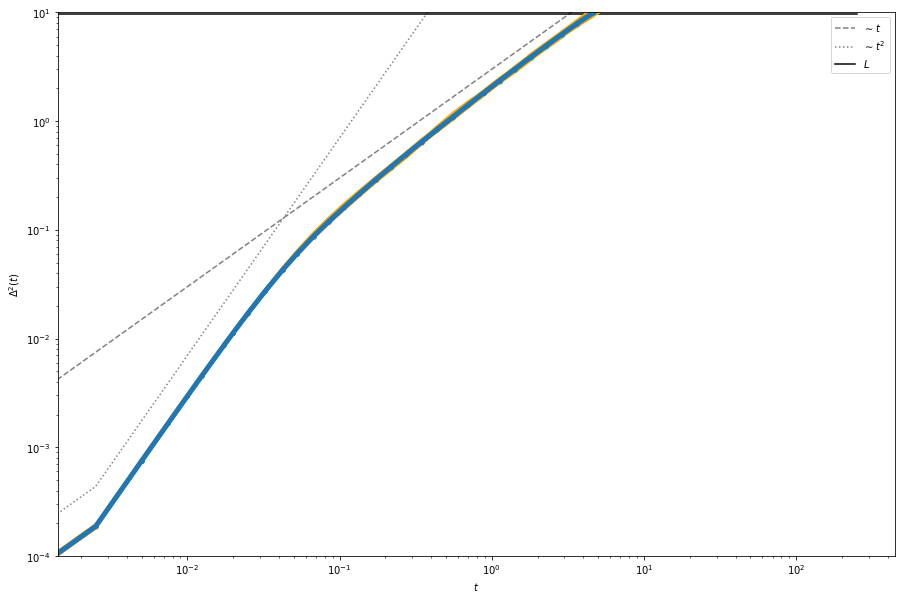

In [10]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.plot(x,3*x,label='$\sim t$',linestyle='--',color='gray')
plt.plot(x,70*np.square(x),label='$\sim t^2$',linestyle=':',color='gray')
plt.plot(x,L*np.ones(len(x)),label='$L$',color='black')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
plt.ylim((1e-4,10))
for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['msd']['mean'],yerr=obs[isam]['msd']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,msd[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['msd']['mean'],yerr=obs[nsamples]['msd']['err'], marker='.',linewidth=5)
plt.legend()
plt.show()



### Self-intermediate scattering function

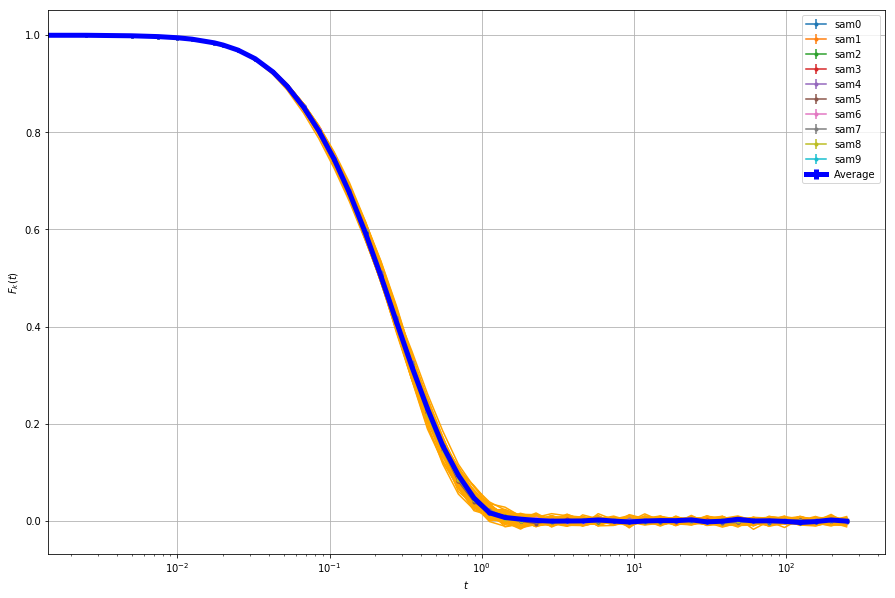

In [11]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
for isam in range(nsamples):
    for itw in range(0,ntw[isam]):
        plt.plot(x,Fk[isam][itw], color='orange')
    plt.errorbar(x,obs[isam]['Fk']['mean'],yerr=obs[isam]['Fk']['err'],label='sam'+str(samples[isam]),marker='.')
plt.errorbar(x,obs[isam]['Fk']['mean'],yerr=obs[isam]['Fk']['err'],label='Average',marker='.',linewidth=5, color='blue')
plt.legend()
plt.ylabel('$F_k(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()



### Momentum-momentum correlation function

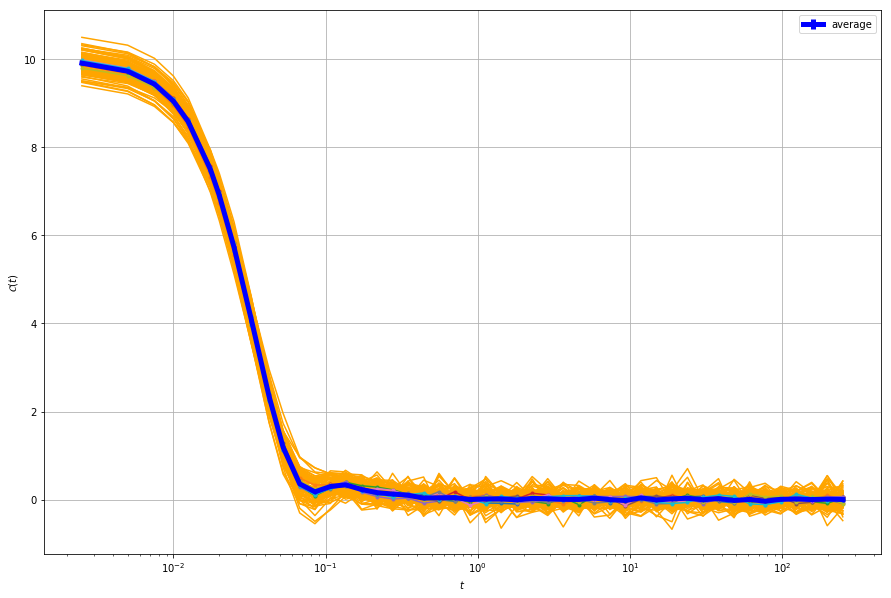

In [12]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')

for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['CPP']['mean'],yerr=obs[isam]['CPP']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CPP[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CPP']['mean'],yerr=obs[nsamples]['CPP']['err'],marker='.',label='average', linewidth=5, color='blue')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-momentum correlation function

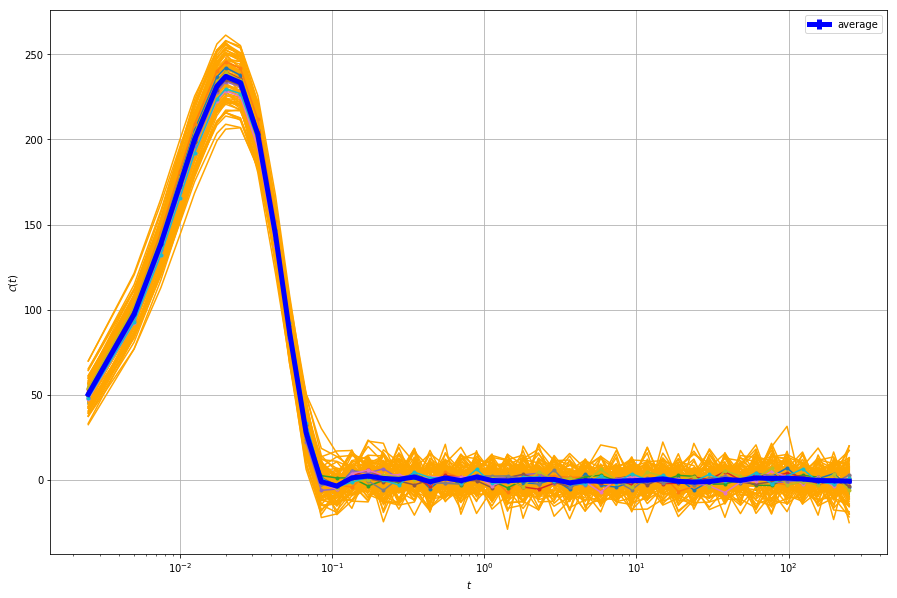

In [13]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['CFP']['mean'],yerr=obs[isam]['CFP']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CFP[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CFP']['mean'],yerr=obs[nsamples]['CFP']['err'],marker='.',label='average', linewidth=5, color='blue')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-force correlation function

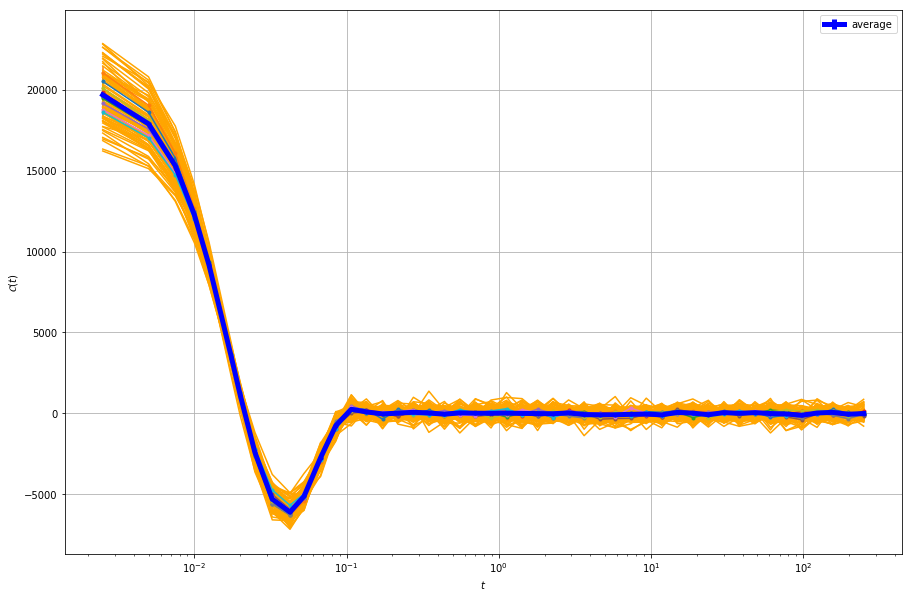

In [14]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
for isam in range(nsamples):    
    plt.errorbar(x,obs[isam]['CFF']['mean'], yerr=obs[isam]['CFF']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CFF[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CFF']['mean'], yerr=obs[nsamples]['CFF']['err'],marker='.',label='average', linewidth=5, color='blue')

plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()


### Diagonal Force correlation

NameError: name 'Cd' is not defined

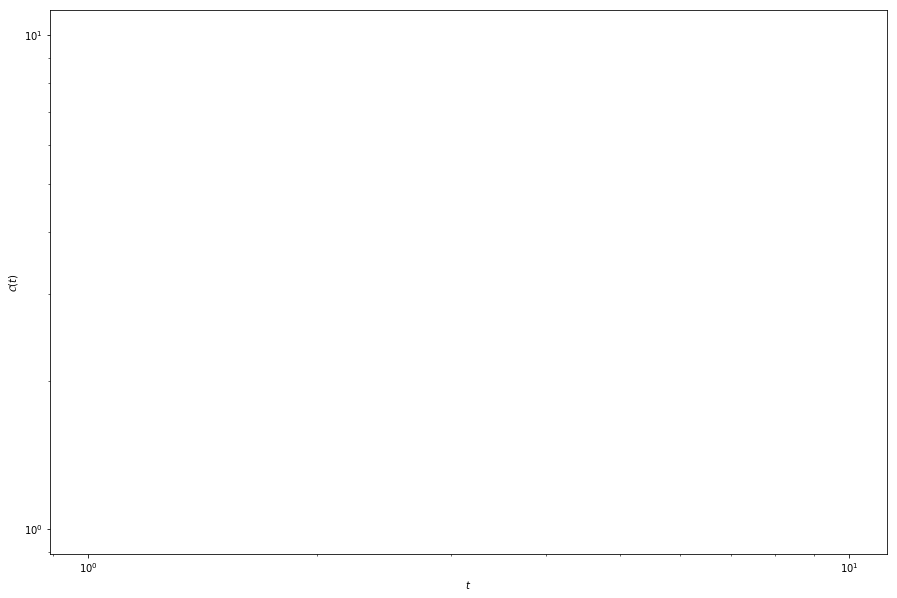

In [15]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
for isam in range(nsamples):
#     plt.errorbar(x,obs[isam]['Cd']['mean'], yerr=obs[isam]['Cd']['err'], marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,Cd[isam][itw], color='orange')
# plt.errorbar(x,obs[nsamples]['Cd']['mean'], yerr=obs[nsamples]['Cd']['err'], marker='.',linewidth=5)
plt.legend()
plt.show()


---------------------------------------------- 
.  
.  
.  
.  
.  
.  
.  
# Noise correlation functions
.   
.    
.     
.      
.       
.        
.         
. 

---------------------------------------------- 


Parameters

In [16]:
scheme='simpson'

#The linear grid
dtfine=0.0025
invT=np.float64(1./T)
xmax=x[-1]/1000
xdatafine=np.arange(0, xmax, dtfine)
NcorrFine=len(xdatafine)
du=xdatafine[1]-xdatafine[0]

Some functions

In [17]:
from scipy.integrate import simps,romb
def integral(myCFP, myKold, myn, dt, scheme='rectangles'):
    '''Integral for the self-consistent calculation'''
    if n==0: return 0
    integrand=np.array([myCFP[myn-i]*myKold[i] for i in range(myn)])

    if scheme   == 'rectangles':
        output=integrand.sum()*dt
    elif scheme == 'trapeze':
        output=np.trapz(integrand,dx=dt)
    elif scheme == 'simpson':
        output=simps(integrand,dx=dt, even='avg')
    else:
        raise NotImplementedError('Integration scheme must be rectangles, trapeze or simpson. '+scheme+' is not a valid option.')
    return output


Interpolation

In [18]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

#Interpolation of the correlators
interpCFF=interp1d(x, obs[nsamples]['CFF']['mean'], kind='cubic')
interpCFP=interp1d(x, obs[nsamples]['CFP']['mean'], kind='cubic')

#Correlators in the linear grid
CFP=np.copy(interpCFP(xdatafine))-obs[nsamples]['CFP']['mean'][0]
CFF=np.copy(interpCFF(xdatafine))
Kold=np.copy(interpCFF(xdatafine))
Kold=np.exp(-xdatafine)
Knew=np.zeros(NcorrFine,dtype=np.float64)


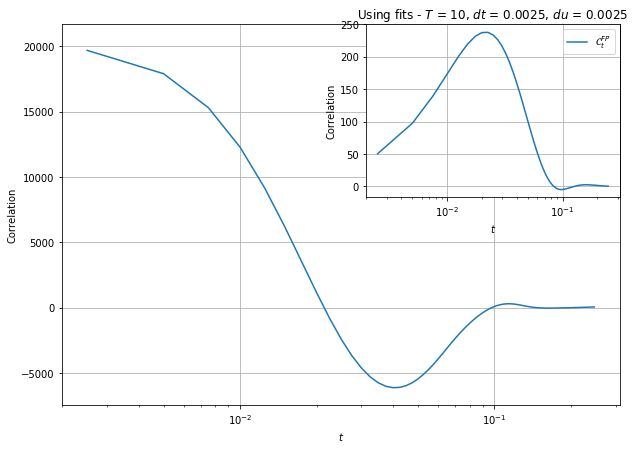

In [19]:
# plt.plot(xdatafine, Knew,label='$\mathcal{K}_t$')
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$')
ax = fig.add_subplot(2, 2, 2)
ax.set_xscale("log", nonposx='mask')
plt.plot(xdatafine, interpCFP(xdatafine),label='$\mathcal{C}^{FP}_t$')
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.title('Using fits - $T$ = %g, $dt$ = %g, $du$ = %g'%(T,dt,du))
plt.show()


### Integration of the noise correlation function

In [20]:
maxiter=1000
for it in range(maxiter):
    for n in range(NcorrFine):
        Knew[n] = CFF[n] + invT * integral(CFP, Kold,n, dtfine,scheme=scheme)
    err=np.max(np.abs(Knew-Kold))
    print("it:",it," err = ",err)
    if err<1e-10: break
    Kold[:]=Knew[:]
#     plt.semilogx(xdatafine, Knew,label='$\mathcal{K}_t$')
#     plt.show()


it: 0  err =  20337.537738715277
it: 1  err =  5359.732426472117
it: 2  err =  3228.456620949406
it: 3  err =  2303.4826464446423
it: 4  err =  1774.5411206032873
it: 5  err =  1426.299127322266
it: 6  err =  1178.7346641147312
it: 7  err =  995.4167743710291
it: 8  err =  853.2405374721411
it: 9  err =  739.9588739562935
it: 10  err =  540.3908590012248
it: 11  err =  260.87816867611724
it: 12  err =  92.44559094832942
it: 13  err =  25.413027849548712
it: 14  err =  5.603842127186198
it: 15  err =  1.0143250943678197
it: 16  err =  0.15330514587370203
it: 17  err =  0.019607215892165186
it: 18  err =  0.0021449883608397613
it: 19  err =  0.0002025073567040181
it: 20  err =  1.6622846800373736e-05
it: 21  err =  1.1939323201204388e-06
it: 22  err =  7.544645086454693e-08
it: 23  err =  4.2144563394685974e-09
it: 24  err =  2.0895640773233026e-10
it: 25  err =  9.237055564881302e-12


NameError: name 'Cd' is not defined

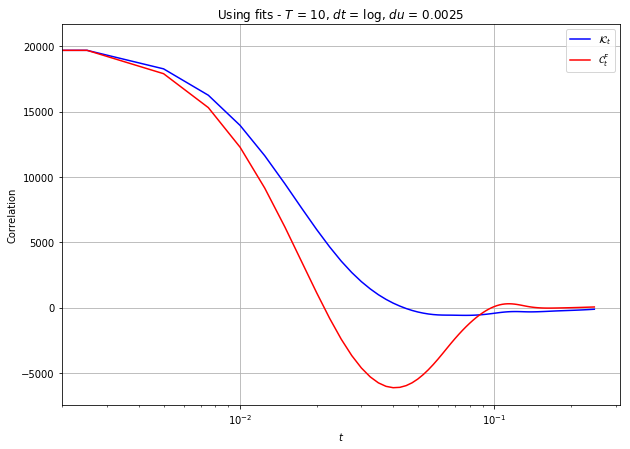

In [21]:
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log")
ax.set_yscale("linear")
plt.plot(xdatafine, Knew,label='$\mathcal{K}_t$',color='blue')
plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$',color='red')
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.title('Using fits - $T$ = %g, $dt$ = log, $du$ = %g'%(T,du))
# plt.xlim((0,1))
# plt.ylim((-1000,2000))


#Compare with Cd
for isam in range(nsamples):
    for itw in range(2):
        plt.plot(x,Cd[isam][itw], color='orange')


plt.show()


# Diagonal correlator

Read the thermalized.gsd, 

define the potential read in the params.in,

create two snapshots and assign them the positions in the heavy trajectory,

calculate Cd.



In [22]:
invT=1./T
pd=med.PeriodicSquareDistance

Cd_old=np.copy(Cd)
Cd  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
for isam in range(nsamples):
    for itw in range(ntw[isam]):
        snapA.particles.position[:] = poslist[isam][itw][0][:]
        for iframe in range(0, nt[isam]):
            snapB.particles.position[:] = poslist[isam][itw][iframe][:]
            Cd[isam][itw][iframe]=pair.Cd_fast(snapA=snapA, snapB=snapB, beta=invT)
            print('isam: %d, itw: %d, it: %d, Cd= %g'%(isam,itw,iframe,Cd[isam][itw][iframe]))
    obs[isam]={
         'Cd' :{'mean': np.mean(Cd [isam],axis=0), 'err': sem(Cd [isam], axis=0)},
    }
obs[nsamples]={'Cd' :{'mean': np.mean(Cd ,axis=(0,1)), 'err': sem(np.mean(Cd , axis=0), axis=0)}}



NameError: name 'Cd' is not defined

NameError: name 'Cd' is not defined

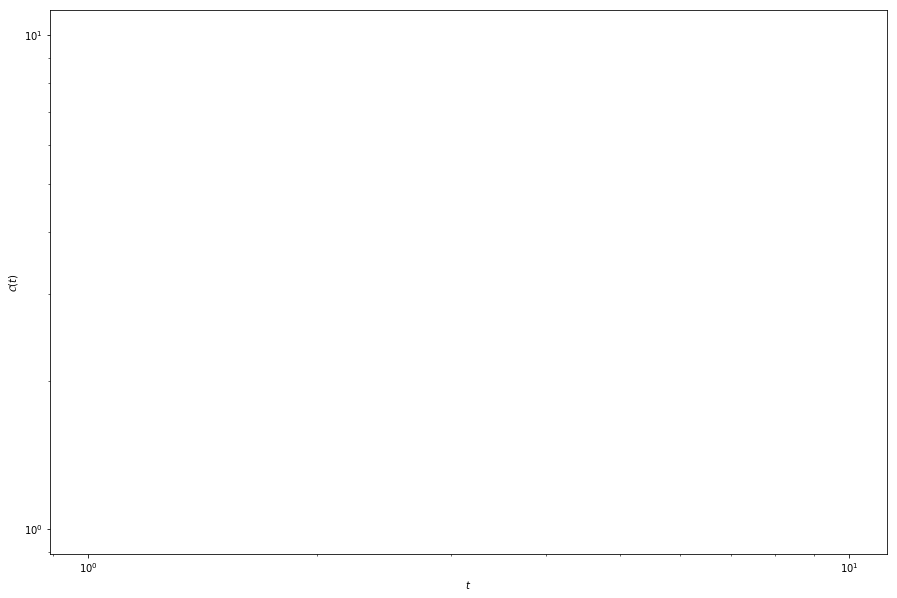

In [23]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
for isam in range(nsamples):
#     plt.errorbar(x,obs[isam]['Cd']['mean'], yerr=obs[isam]['Cd']['err'], marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,Cd[isam][itw], color='orange')
# plt.errorbar(x,obs[nsamples]['Cd']['mean'], yerr=obs[nsamples]['Cd']['err'], marker='.',linewidth=5)
plt.legend()
plt.show()
